In [1]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

train_df = pd.read_csv("./split-data/train_new.csv")
test_df = pd.read_csv("./split-data/test_new.csv")
val_df = pd.read_csv("./split-data/val_new.csv")

In [3]:
traingen=ImageDataGenerator(rescale= 1./255)
train_generator=traingen.flow_from_dataframe(
dataframe=train_df,
directory="./dataset",
x_col="img_path",
y_col= "category",
batch_size=128,
shuffle= True,
target_size = (256,256),
class_mode="categorical",
workers=4
)

valgen = ImageDataGenerator(rescale=1./255)
val_generator = valgen.flow_from_dataframe(
    dataframe=val_df,
    directory="./dataset",
    x_col="img_path",
    y_col="category",
    target_size=(256, 256),
    batch_size=128,
    class_mode="categorical",
    workers=4
)

Found 4011 validated image filenames belonging to 46 classes.
Found 3139 validated image filenames belonging to 46 classes.


In [4]:
from keras.models import Model
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import SGD,Adam
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from keras import backend as K
from keras.layers import Dense, Flatten
from tensorflow.keras.applications.densenet import DenseNet121

In [7]:
# Load pretrained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add new classification head
flat1 = Flatten()(base_model.output)
num_classes = 46
output = Dense(num_classes, activation='softmax')(flat1)

# Define model
model = Model(inputs=base_model.inputs, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]



In [8]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Epoch 1/10


2024-12-01 19:41:32.928851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 4.0577 - accuracy: 0.0244 - top_k_categorical_accuracy: 0.1419

2024-12-01 19:45:01.411331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 377s 12s/step - loss: 4.0577 - accuracy: 0.0244 - top_k_categorical_accuracy: 0.1419 - val_loss: 3.8629 - val_accuracy: 0.0395 - val_top_k_categorical_accuracy: 0.1695 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 372s 12s/step - loss: 3.8423 - accuracy: 0.0386 - top_k_categorical_accuracy: 0.1660 - val_loss: 3.7465 - val_accuracy: 0.0446 - val_top_k_categorical_accuracy: 0.1934 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 424s 13s/step - loss: 3.7350 - accuracy: 0.0494 - top_k_categorical_accuracy: 0.1997 - val_loss: 3.6660 - val_accuracy: 0.0558 - val_top_k_categorical_accuracy: 0.2278 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 430s 14s/step - loss: 3.6527 - accuracy: 0.0613 - top_k_categorical_accuracy: 0.2396 - val_loss: 3.5978 - val_accuracy: 0.0679 - val_top_k_categorical_accuracy: 0.2641 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 392s 12s/st

In [9]:
# save the model to a file
model.save("model.h5")

In [12]:
# test the model
testgen = ImageDataGenerator(rescale=1./255)
test_generator = testgen.flow_from_dataframe(
    dataframe=test_df,
    directory="./dataset",
    x_col="img_path",
    y_col="category",
    target_size=(256, 256),
    batch_size=128,
    class_mode="categorical",
    workers=4
)

Found 3133 validated image filenames belonging to 46 classes.


In [24]:
# test using the first element of test_generator
x, y = test_generator[0]
y_pred = model.predict(x)

# compare the predicted labels to the true labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y, axis=1)

# calculate accuracy
accuracy = np.mean(y_pred == y_true)
print(f"Accuracy: {accuracy}")


4/4 [==============================] - 6s 1s/step
Accuracy: 0.171875


Predicted label: 4


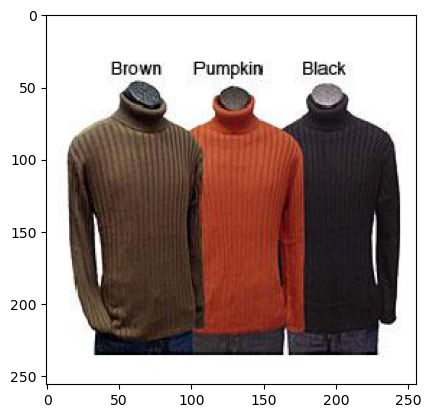

In [25]:
# plot the first image
import matplotlib.pyplot as plt
plt.imshow(x[0])

# print the predicted label
print(f"Predicted label: {y_pred[0]}")